# LSI convergence for log-concave marginals

In [2]:
%pip install emcee
%pip install scikit-learn
%pip install pot

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 KB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 37.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 KB 45.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 KB 10.8 MB/s eta 0:00:0031m12.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np

In [4]:
from LSI_helpers import epsilon_c, kappa_X_given_Y, kappa_Y_given_X, rate_r
from wasserstein_distances import W2_empirical
from EM import euler_maruyama_coupling

In [5]:
delta = 0.1

def U(x):
    return 0.5 * x**2 + delta * np.sin(x)**2

def grad_U(x):
    return x + delta * np.sin(2*x)

def V(y):
    return 1.5 * y**2 + delta * np.sin(y)**2

def grad_V(y):
    return 3.0 * y + delta * np.sin(2*y)

In [6]:
alpha_u, beta_u = 0.8, 1.2
alpha_v, beta_v = 2.8, 3.2

eps = 0.2       # must exceed ε_c for these U, V
N = 1000        # number of particles
dt = 1e-3       # time-step
T = 5.0         # final time

eps_c_val = epsilon_c(alpha_u, alpha_v, beta_u, beta_v)
kX = kappa_X_given_Y(alpha_u, beta_v, eps)
kY = kappa_Y_given_X(alpha_v, beta_u, eps)
r_val = rate_r(kX, kY, eps)

steps = int(T / dt)
times = np.linspace(0.0, T, steps + 1)

## MCMC sampling from $\exp{-U(x)}$ and $\exp{-V(y)}$ 

In [7]:
import emcee

# (Assume U(x), V(y), and rng are already defined above.)

# 1) Define log‐probability for U
def log_prob_U(theta):
    x = theta[0]          # theta is a length-1 array [x]
    return -U(x)          # log π₁(x) = −U(x)

# 2) Sampler parameters
ndim     = 1
nwalkers = 40
nburn    = 1000
nsteps   = 125

# 3) Initialize walkers for U
rng = np.random.default_rng(0)
p0 = rng.normal(loc=0.0, scale=0.1, size=(nwalkers, ndim))

# 4) Burn-in for U
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_U)
pos, _, _ = sampler.run_mcmc(p0, nburn, progress=False)

# 5) Production for U
sampler.reset()
sampler.run_mcmc(pos, nsteps, progress=False)

# 6) Extract U-samples
chain = sampler.get_chain(flat=True)   # shape = (nwalkers * nsteps, ndim)
X0 = chain[:, 0]
print("Collected", X0.shape[0], "samples from π(x) ∝ exp(-U(x)).")

# —————————————————————————————————————————————

# 7) Define log‐probability for V
def log_prob_V(theta):
    y = theta[0]
    return -V(y)          # log π₂(y) = −V(y)

# 8) Initialize walkers for V (this was missing)
p0_V = rng.normal(loc=0.0, scale=0.1, size=(nwalkers, ndim))

# 9) Burn-in for V
sampler_V = emcee.EnsembleSampler(nwalkers, ndim, log_prob_V)
pos_V, _, _ = sampler_V.run_mcmc(p0_V, nburn, progress=False)

# 10) Production for V
sampler_V.reset()
sampler_V.run_mcmc(pos_V, nsteps, progress=False)

# 11) Extract V-samples
chain_V = sampler_V.get_chain(flat=True)
Y0 = chain_V[:, 0]
print("Collected", Y0.shape[0], "samples from π(y) ∝ exp(-V(y)).")


Collected 5000 samples from π(x) ∝ exp(-U(x)).
Collected 5000 samples from π(y) ∝ exp(-V(y)).


## EM scheme

In [8]:
dt = 0.01
eps = 0.5
num_steps = 500
T = num_steps*dt
errors, X_traj, Y_traj, _, mY_hist, mX_hist = euler_maruyama_coupling(
    X0,
    Y0,
    epsilon=eps,
    T=T,
    N=num_steps,
    cond_method='isotonic',
    h=None,
    k=None,
    grad_U=grad_U,
    grad_V=grad_V,
    compute_W2_sq=None,
    seed=42
)
emp_wasserstein = W2_empirical(X0, Y0)
print(emp_wasserstein)

0.3699651774407905


In [45]:
# 1. Evaluate the unnormalized “pdf” of μ at each X0[i]:  wX_raw[i] = e^{-U(X0[i])}
wX_raw = np.exp(-U(X0))        # shape: (N,)

# 2. Normalize so that sum_i a[i] = 1
a = wX_raw / np.sum(wX_raw)    # shape: (N,)

# 3. Do the same for ν:  wY_raw[j] = e^{-V(Y0[j])}
wY_raw = np.exp(-V(Y0))        # shape: (N,)
b = wY_raw / np.sum(wY_raw)    # shape: (N,)

# -------------------------------------------------------------------------
# B) Build the cost matrix M_{ij} = (X0[i] - Y0[j])^2   (or 0.5*(x-y)^2 if you prefer)
# -------------------------------------------------------------------------
# If you want c(x,y)=|x-y|^2, then:
M = (X0.reshape(-1, 1) - Y0.reshape(1, -1))**2 

In [46]:
import ot

In [51]:
dt = 0.01
errors_dict = {}
W_eps_dict  = {}
eps_list = [1e-3, 1e-1, 0.4, 3.0]
num_steps = 500
ab = np.outer(a, b)
T = num_steps*dt
for eps in eps_list:
    errors, X_traj, Y_traj, _, mY_hist, mX_hist = euler_maruyama_coupling(
        X0,
        Y0,
        epsilon=eps,
        T=T,
        N=num_steps,
        cond_method='isotonic',
        h=None,
        k=None,
        grad_U=grad_U,
        grad_V=grad_V,
        compute_W2_sq=None,
        seed=42
    )

    errors_dict[eps] = np.asarray(errors)
    P_es = ot.bregman.sinkhorn_epsilon_scaling(
            a,
            b,
            M,
            eps,
            stopThr=1e-9,
            numItermax=1000,
            tau=1e6,
        )


    log_ratio = np.log(P_es) - np.log(ab)
    entropy_term = eps * np.sum(P_es * log_ratio)
    W_es = np.sum(P_es*M)
    W_eps_dict[eps] = W_es
    

/home/karapas/.local/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:1331: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/tmp/ipykernel_50036/2989007643.py:36: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(P_es) - np.log(ab)
/tmp/ipykernel_50036/2989007643.py:37: RuntimeWarning: invalid value encountered in multiply
  entropy_term = eps * np.sum(P_es * log_ratio)


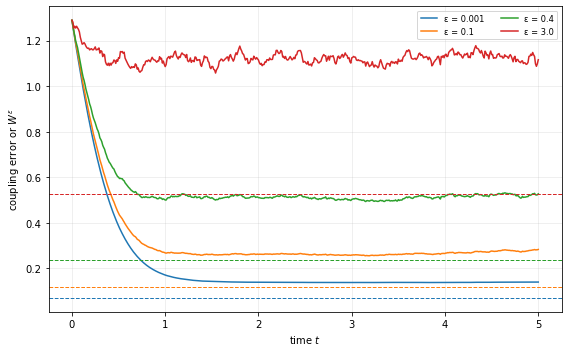

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
cmap = plt.get_cmap('tab10')
t_vec = np.linspace(0.0, T, num_steps + 1)

for idx, eps in enumerate(eps_list):
    color = cmap(idx % 10)

    # Plot error(t) as a solid line, label only shows ε value
    plt.plot(
        t_vec,
        errors_dict[eps],
        color=color,
        linewidth=1.5,
        label=f"ε = {eps}"
    )

    # Plot horizontal dashed line at W_ε (no legend entry)
    Wval = W_eps_dict[eps]
    if Wval is not None:
        plt.axhline(
            y=Wval,
            color=color,
            linestyle='--',
            linewidth=1.0,
            label="_nolegend_"
        )

plt.xlabel("time $t$")
plt.ylabel("coupling error or $W^ε$")
plt.grid(alpha=0.25)

# Legend with two columns, only ε values appear
plt.legend(loc='upper right', fontsize='small', ncol=2)
# plt.savefig()
plt.tight_layout()
plt.show()

In [9]:
alpha_u = 0.8
beta_u  = 1.2
alpha_v = 2.8
beta_v  = 3.2

eps_c_val = epsilon_c(alpha_u, alpha_v, beta_u, beta_v)
print(eps_c_val)

0.15748519708717798


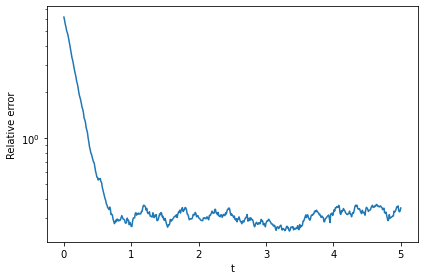

In [10]:
import matplotlib.pyplot as plt

times = np.arange(num_steps + 1) * dt
rel_error = (errors - emp_wasserstein)**2 / emp_wasserstein**2

plt.figure()
plt.plot(times, rel_error)
plt.xlabel('t')
plt.ylabel('Relative error')
plt.yscale('log')
plt.tight_layout()
plt.show()

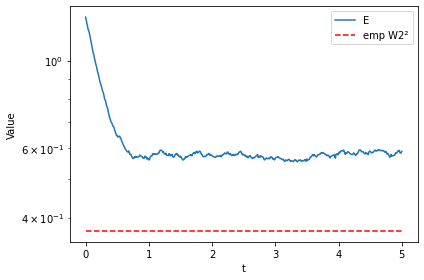

In [11]:
times = np.arange(num_steps + 1) * dt

plt.figure()
plt.plot(times, errors, label='E')
plt.hlines(emp_wasserstein, times[0], times[-1],
           colors='r', linestyles='--', label='emp W2²')
plt.xlabel('t')
plt.ylabel('Value')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
P_es = ot.bregman.sinkhorn_epsilon_scaling(
            a,
            b,
            M,
            eps,
            stopThr=1e-9,
            numItermax=1000,
            tau=1e6,
        )

W_es = np.sum(P_es*M)
print(W_es)

0.2658835314439504


In [55]:
from wasserstein_distances import entropic_wasserstein_gaussian_1d
eps_list = [1e-3, 1e-1, 1.0, 3.0, 5.0, 10.0, 20.0]
dt        = 5e-3
num_steps = int(3e3)
T         = num_steps * dt

errors_dict = {}
W_eps_dict  = {}

m0 = 3
K0 = 5
m1 = 7
K1 = 10
n_samples = int(5e3)

def grad_Ug(x):
    # ∇U(x) = (x - m0) / K0
    return (x - m0) / K0

def grad_Vg(y):
    # ∇V(y) = (y - m1) / K1
    return (y - m1) / K1

rng = np.random.default_rng(42)
X0_samples = rng.normal(loc=m0, scale=np.sqrt(K0), size=n_samples)
Y0_samples = rng.normal(loc=m1, scale=np.sqrt(K1), size=n_samples)

for eps in eps_list:
    errors, X_traj, Y_traj, _, mY_hist, mX_hist = euler_maruyama_coupling(
        X0_samples,
        Y0_samples,
        epsilon=eps,
        T=T,
        N=num_steps,
        cond_method='isotonic',
        h=None,
        k=None,
        grad_U=grad_Ug,
        grad_V=grad_Vg,
        compute_W2_sq=None,
        seed=42
    )

    errors_dict[eps] = np.asarray(errors)

    if eps > 0.0:
        W_eps = entropic_wasserstein_gaussian_1d(m0, K0, m1, K1, eps)
        W_eps_dict[eps] = W_eps
    else:
        # Skip W_eps for eps=0
        W_eps_dict[eps] = None

emp_wasserstein = W2_empirical(X0_samples, Y0_samples)
print("Empirical W₂ between X0_samples and Y0_samples:", emp_wasserstein)

Empirical W₂ between X0_samples and Y0_samples: 4.157739871101452


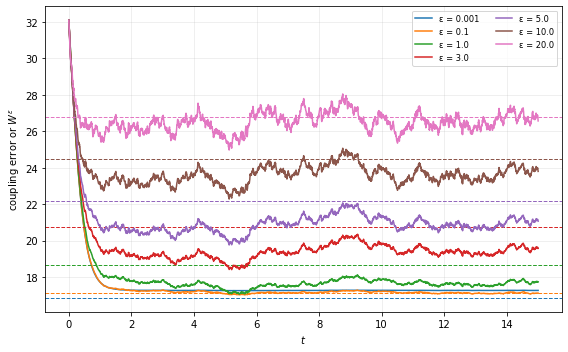

In [59]:
plt.figure(figsize=(8, 5))
cmap = plt.get_cmap('tab10')
t_vec = np.linspace(0.0, T, num_steps + 1)

for idx, eps in enumerate(eps_list):
    color = cmap(idx % 10)

    # Plot error(t) as a solid line, label only shows ε value
    plt.plot(
        t_vec,
        errors_dict[eps],
        color=color,
        linewidth=1.5,
        label=f"ε = {eps}"
    )

    # Plot horizontal dashed line at W_ε (no legend entry)
    Wval = W_eps_dict[eps]
    if Wval is not None:
        plt.axhline(
            y=Wval,
            color=color,
            linestyle='--',
            linewidth=1.0,
            label="_nolegend_"
        )

plt.xlabel("$t$")
plt.ylabel("coupling error or $W^ε$")
plt.grid(alpha=0.25)

# Legend with two columns, only ε values appear
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.savefig('convergence_gaussian')
plt.tight_layout()
plt.show()

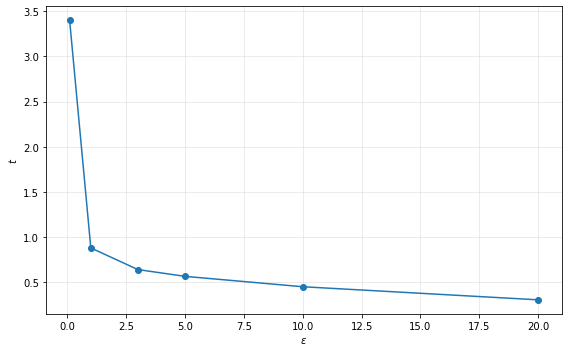

In [65]:
cross_times = {}
for eps in eps_list:
    if eps > 0.0:
        Wval = W_eps_dict[eps]
        err = errors_dict[eps]  # shape = (num_steps+1,)
        # Find all indices k where err[k] ≤ Wval
        idxs = np.where(err <= Wval)[0]
        if idxs.size > 0:
            cross_times[eps] = t_vec[idxs[0]]
        else:
            # If it never goes below or equal, record NaN
            cross_times[eps] = np.nan
    else:
        cross_times[eps] = np.nan

# Pull out arrays of eps>0 only
eps_positive = [eps for eps in eps_list if eps > 0.0]
times_to_cross = [cross_times[eps] for eps in eps_positive]

plt.figure(figsize=(8, 5))
plt.plot(
    eps_positive,
    times_to_cross,
    marker='o',
    linestyle='-',
    color='tab:blue'
)
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$t$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("crossing_time_vs_epsilon.png", dpi=300)
plt.show()

In [61]:
alpha_u = beta_u = 1.0 / K0
alpha_v = beta_v = 1.0 / K1 

In [62]:
r_dict = {}
for eps in eps_list: 
    if eps == 0.0:
        r_dict[eps] = 0.0
        continue
    kxgy = kappa_X_given_Y(alpha_u, beta_v, eps)
    kygx = kappa_Y_given_X(alpha_v, beta_u, eps)
    r_dict[eps] = rate_r(kxgy, kygx, eps)

# ------------------------------------------------------------------
t_vec = np.linspace(0.0, T, num_steps + 1)

exp_curves = {}
for eps in eps_list:
    if eps == 0.0 or W_eps_dict[eps] is None:
        continue
    Wplateau = W_eps_dict[eps]
    E0        = errors_dict[eps][0]
    r_val     = r_dict[eps]

    exp_curves[eps] = Wplateau + (E0 - Wplateau) * np.exp(-r_val * t_vec)

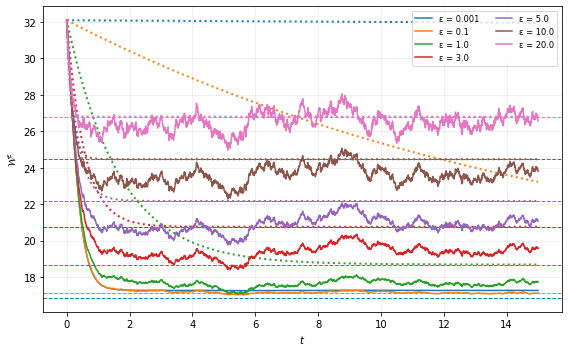

In [ ]:
plt.figure(figsize=(8, 5))
cmap = plt.get_cmap("tab10")

for idx, eps in enumerate(eps_list):
    color = cmap(idx % 10)

    # (i) empirical error curve (solid)
    plt.plot(t_vec,
             errors_dict[eps],
             color=color,
             linewidth=1.5,
             label=f"ε = {eps}")

    # (ii) horizontal plateau at W^ε  (dashed)  — only if eps>0
    Wval = W_eps_dict[eps]
    if Wval is not None:
        plt.axhline(y=Wval,
                    color=color,
                    linestyle='--',
                    linewidth=1.0,
                    label="_nolegend_")

    # (iii) theoretical exponential (dotted)  — only if eps>0
    if eps in exp_curves:
        plt.plot(t_vec,
                 exp_curves[eps],
                 color=color,
                 linestyle=':',
                 linewidth=2.0,
                 label="_nolegend_")

plt.xlabel(r"$t$")
plt.ylabel(r"$\mathcal{W}^{\varepsilon}$")
plt.grid(alpha=0.25)
plt.legend(ncol=2, fontsize="small", loc="upper right")
plt.tight_layout()
plt.savefig("LSI_convergence_gaussians.png", dpi=300)
plt.show()

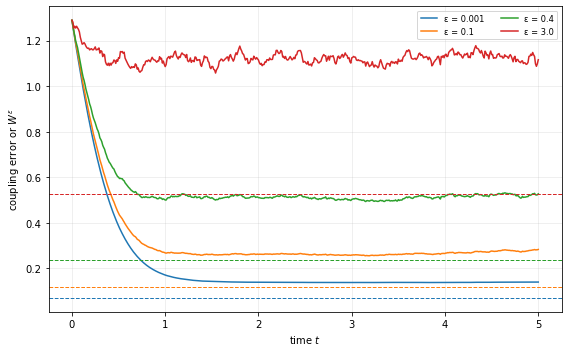

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
cmap = plt.get_cmap('tab10')
t_vec = np.linspace(0.0, T, num_steps + 1)

for idx, eps in enumerate(eps_list):
    color = cmap(idx % 10)

    # Plot error(t) as a solid line, label only shows ε value
    plt.plot(
        t_vec,
        errors_dict[eps],
        color=color,
        linewidth=1.5,
        label=f"ε = {eps}"
    )

    # Plot horizontal dashed line at W_ε (no legend entry)
    Wval = W_eps_dict[eps]
    if Wval is not None:
        plt.axhline(
            y=Wval,
            color=color,
            linestyle='--',
            linewidth=1.0,
            label="_nolegend_"
        )

plt.xlabel("time $t$")
plt.ylabel("coupling error or $W^ε$")
plt.grid(alpha=0.25)

# Legend with two columns, only ε values appear
plt.legend(loc='upper right', fontsize='small', ncol=2)
# plt.savefig()
plt.tight_layout()
plt.show()